In [1]:
#! Python3
# useful libs
import numpy as np
import operator
import re
import collections
import nltk
from difflib import ndiff
import seaborn as sns
import numpy.linalg as la
import six

# Preprocessing
from gensim.utils import lemmatize

# vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import normalize

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
import warnings
warnings.filterwarnings('ignore')

# (a) Data Import

In [2]:
sentances, scores = [], []


In [3]:
!gdown --id 1P8jSclCPfpFtTMdXzZy3D9DPTs9yOhb5

Downloading...
From: https://drive.google.com/uc?id=1P8jSclCPfpFtTMdXzZy3D9DPTs9yOhb5
To: /content/RTOnoLocWpol3.csv
100% 41.6M/41.6M [00:00<00:00, 53.3MB/s]


In [88]:
import pandas as pd
df = pd.read_csv("RTOnoLocWpol3.csv")

In [89]:
df.head()
# saving the first 500 df elements , remove this to run on full data
#df = df[:100]

,Unnamed: 0,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,polarity
0,0,3798,48750,@Gotham2Face,2021-12-12 23:59:39+00:00,"@Gotham2Face Talia waits for Harvey’s return, ...",positive,0.087500
1,1,3799,48751,"Genève, Suisse",2021-12-12 23:56:07+00:00,The Obamas Return to Chicago https://t.co/uqvJ...,neutral,0.000000
2,2,3800,48752,STATEWIDE BABY,2021-12-12 23:52:35+00:00,@mrosen23 @BrrrBailey @Puleo_Andrew @NYSPEF An...,positive,0.022487
3,3,3801,48753,"30.399941,-97.705223",2021-12-12 23:47:33+00:00,Being a creator is high esteem and realistic. ...,positive,0.108889
4,4,3802,48754,"30.399941,-97.705223",2021-12-12 23:47:33+00:00,The biggest driving force for office returns s...,positive,0.107143


In [59]:
len(df.Location.unique())

69

In [90]:
df.dropna(inplace=True)

In [91]:
df.count()

Unnamed: 0       118907
UserName         118907
ScreenName       118907
Location         118907
TweetAt          118907
OriginalTweet    118907
Sentiment        118907
polarity         118907
dtype: int64

In [92]:
df.head()

,Unnamed: 0,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,polarity
0,0,3798,48750,@Gotham2Face,2021-12-12 23:59:39+00:00,"@Gotham2Face Talia waits for Harvey’s return, ...",positive,0.087500
1,1,3799,48751,"Genève, Suisse",2021-12-12 23:56:07+00:00,The Obamas Return to Chicago https://t.co/uqvJ...,neutral,0.000000
2,2,3800,48752,STATEWIDE BABY,2021-12-12 23:52:35+00:00,@mrosen23 @BrrrBailey @Puleo_Andrew @NYSPEF An...,positive,0.022487
3,3,3801,48753,"30.399941,-97.705223",2021-12-12 23:47:33+00:00,Being a creator is high esteem and realistic. ...,positive,0.108889
4,4,3802,48754,"30.399941,-97.705223",2021-12-12 23:47:33+00:00,The biggest driving force for office returns s...,positive,0.107143


In [63]:
df.Sentiment =df.Sentiment.map(dict(positive=1, neutral=0 , negative=0))

In [64]:
sentances = list(df.OriginalTweet)

In [65]:
scores = list(df.Sentiment)

In [66]:
counter = collections.Counter(scores)
print(counter)

Counter({1: 41, 0: 37})


### Explanation
Yes the labels are balanced. 
By reading each line of the training txt files, we got lists of sentences and scores. 
Using collection.Counter, we get to know the number of each label in the score lists. 


# (b) Preprocessing

In [67]:
!pip install pattern

In [68]:


def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub("@","", text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text




In [69]:
sentences_processed = []
for i in sentances :
  sentences_processed.append(clean_text(i))

In [70]:
sentences_processed

[' talia waits for harvey’s return, bruce getting up from bed and going to his office where he spent plenty of evenings holed away. it always made the manor feel larger, somehow. like she was kept out of the way one end, far away from everyone else even if it wasn’t entirely true. —',
 'the obamas return to chicago  via obamafoundation',
 " brrrbailey puleo_andrew nyspef anything less than filing suit to stop return to office with a #delta #omicron combined surge about to slam ny (generally  weeks behind uk) is a half-measure. our members are catching #covid left and right while hq appears to be doing nothing. we'd love to be proven wrong.",
 'being a creator is high esteem and realistic. % of gen z report being a freelancer, and, they are in a life place to swap our corporate life for freelance. gen z will limit the ability for execs to mandate a return to office.',
 'the biggest driving force for office returns seems to be executives within certain demographics, but gen z is differen

### Preprocessing explanations
1) We should lowercase all of the words, because capitalized letters with make same words be treated as different ones.

2) We should strip punctuations because they do not contribute to sentiment.

3) Stop words are the most commonly occuring words which are not relevant in the context of the data and do not contribute any deeper meaning to the phrase. In this case contain no sentiment.

4) We should do lemmatization.This process finds the base or dictionary form of the word known as the lemma. This is done through the use of vocabulary (dictionary importance of words) and morphological analysis (word structure and grammar relations). This normalization is similar to stemming but takes into account the context of the word.

Visualization of sentiment distribution 

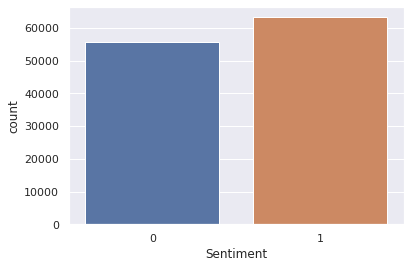

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")

ax = sns.countplot(x="Sentiment", data=df)

Location count

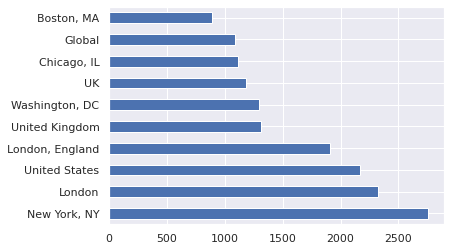

In [ ]:
df.Location.value_counts()[:10].plot(kind='barh')

heatmap

In [ ]:
s=df.Location.value_counts()[:10]

In [ ]:
s

New York, NY       2754
London             2321
United States      2172
London, England    1910
United Kingdom     1312
Washington, DC     1293
UK                 1180
Chicago, IL        1115
Global             1091
Boston, MA          886
Name: Location, dtype: int64

In [ ]:
'''
#counts = df.Location[:1000].apply(pd.value_counts).fillna(0)

# plot
sns.heatmap(s, cmap="GnBu", annot=True)
'''

'\n#counts = df.Location[:1000].apply(pd.value_counts).fillna(0)\n\n# plot\nsns.heatmap(s, cmap="GnBu", annot=True)\n'

# (c) Split Training and Testing Set

In [71]:
from sklearn.model_selection import train_test_split

In [72]:
train_x, test_x, train_y, test_y = train_test_split(sentances, scores, test_size=0.33, random_state=42)

## (d) Bag of Words
Why should we vectorize training set first and then go through testing set?<br/>
1) Here we should vectorize the training set standalone because testing set could contain words that are not contained in training set. <br/>
2) We will vectorize testing set based on the feature vector generated by training set. 

In [21]:
pip install sentence_transformers

     |████████████████████████████████| 78 kB 4.9 MB/s 
     |████████████████████████████████| 3.4 MB 40.5 MB/s 
     |████████████████████████████████| 3.3 MB 24.3 MB/s 
     |████████████████████████████████| 1.2 MB 34.6 MB/s 
     |████████████████████████████████| 61 kB 449 kB/s 
     |████████████████████████████████| 895 kB 34.9 MB/s 
     |████████████████████████████████| 596 kB 56.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=f18e28e138648180cfbdcf3aebcbb7172416a3b144c3ea7d68396724d4532c23
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [25]:
from sentence_transformers import SentenceTransformer

In [27]:
model = SentenceTransformer('bert-base-nli-mean-tokens')



In [73]:
def Trans(listm):
  topic = [] 
  for i in listm:
    topic.append(model.encode(i))
  return topic

In [74]:
#train_vectorizer = CountVectorizer()
# d.1. build a dictionary of unique words for training set
train_x_bag = Trans(train_x)
#test_vectorizer = test_x
test_x_bag = Trans(test_x)
# d.2. Report feature vectors of 2 reviews
print(train_x[10])
print(train_x_bag[10])
print(train_x[0])
print(train_x_bag[0])

“…He tested negative for Covid-19 upon his return to Johannesburg (from his trip to West Africa) on December 8, according to his office.” - @CNN
[-3.59237581e-01  7.32816849e-03  4.73879308e-01  4.04198110e-01
  5.32125711e-01 -1.03711927e+00  5.02237976e-01  3.75301123e-01
  1.58941850e-01 -3.40558857e-01  2.18149483e-01  2.16084883e-01
  3.99286598e-01  1.26690984e-01 -9.39310491e-02  4.23610449e-01
  4.73001190e-02  2.55866945e-01 -2.27700435e-02 -3.13383132e-01
 -2.87546843e-01 -4.95747000e-01 -3.01331133e-02  8.55240643e-01
  1.07714319e+00  2.30393514e-01  3.16341296e-02 -3.18536162e-01
 -9.51186359e-01  7.29514584e-02 -5.00013828e-01  4.36031789e-01
 -3.22619528e-01  3.00838023e-01  2.75500149e-01  6.20599210e-01
 -3.60186785e-01  4.09453094e-01 -8.32701400e-02  3.82049292e-01
 -4.48355615e-01  2.49530986e-01  8.88753906e-02 -4.89808530e-01
 -8.65120232e-01 -3.19673955e-01  1.17922008e+00  6.45602107e-01
  1.00452983e+00 -1.15133703e+00  3.67764562e-01  6.04355812e-01
  9.750097

In [47]:
train_x_bag

[array([-5.81578240e-02,  1.28879517e-01,  1.36976492e+00,  2.21230119e-01,
         4.06302065e-01, -1.10933113e+00, -3.67243588e-02,  1.51864439e-01,
         6.58412397e-01, -6.20739102e-01,  5.59005618e-01,  1.12738860e+00,
         6.69471562e-01, -1.51372761e-01, -9.06619906e-01,  1.84102327e-01,
         2.74840862e-01, -4.78840798e-01,  3.59935373e-01, -4.76945251e-01,
        -2.41968960e-01, -5.29345572e-01,  2.96196699e-01,  4.00302142e-01,
         8.51370394e-01,  3.66436988e-02, -3.75709206e-01, -8.12791288e-01,
        -1.03330898e+00,  5.25019944e-01, -1.97394818e-01,  6.27298951e-01,
        -9.80920255e-01, -3.41364235e-01, -5.48324406e-01,  1.14199865e+00,
         1.41266000e+00,  2.19945744e-01,  6.12397730e-01,  1.24675654e-01,
         3.57727349e-01, -2.44760215e-02, -3.03958952e-01,  3.66031565e-02,
        -9.96735513e-01, -2.59711623e-01, -1.04161248e-01,  1.01489626e-01,
         1.34511065e+00, -1.77291811e+00,  1.74063236e-01,  1.05959870e-01,
        -1.2

## (e) Postprocessing strategy
We choose L2 normalization as post-processing method, because:<br/>
1) L2 presents the inner product of a vector on itself, representing the length of the vector<br/>
2) The similarity between 2 vectors are calculated by their inner product, which is the format of L2<br/>
3) So L2 would be an ideal way to constrain the value range of each feature into (0, 1)

In [75]:
# post-processing
train_x_bag_normal = normalize(train_x_bag)
test_x_bag_normal = normalize(test_x_bag)

## (f) Sentiment prediction

In [76]:
def sentiment_prediction(Train_X, Train_Y, Test_X, Test_Y):
    # f.1 Logistic regression
    lr_clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(Train_X, Train_Y)
    lr_clf_score = lr_clf.score(Test_X, Test_Y)
    print("Logistic regression accuracy: {}".format(lr_clf_score))
    
    # f.2 Naive Bayes classifier
    # Gaussian
    gaussian_nb = GaussianNB()
    gaussian_nb.fit(Train_X, Train_Y)
    gaussian_nb_score = gaussian_nb.score(Test_X, Test_Y)
    print("Accuracy of Naive Bayes Classifier with Gaussian prior: {}".format(gaussian_nb_score))

    # Bernoulli
    b_nb = BernoulliNB()
    b_nb.fit(Train_X, Train_Y)
    b_nb_score = b_nb.score(Test_X, Test_Y)
    print("Accuracy of Naive Bayes Classifier with Bernoulli prior: {}".format(b_nb_score))
    
    return lr_clf_score, gaussian_nb_score, b_nb_score

In [77]:
sentiment_prediction(train_x_bag_normal, train_y, test_x_bag_normal, test_y)

Logistic regression accuracy: 0.7307692307692307
Accuracy of Naive Bayes Classifier with Gaussian prior: 0.7307692307692307
Accuracy of Naive Bayes Classifier with Bernoulli prior: 0.7307692307692307


(0.7307692307692307, 0.7307692307692307, 0.7307692307692307)

### Comparison of classifiers:
Logistic regression model is slightly better than Naive Bayes classifiers. 

## (g) N-gram model

In [79]:
# Vectorize with 2-gram model
train_vectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
# build a dictionary of unique words for training set
train_x_2gram = train_vectorizer_2gram.fit_transform(train_x).todense()
test_vectorizer_2gram = CountVectorizer(ngram_range=(2, 2), vocabulary=train_vectorizer_2gram.get_feature_names())
test_x_2gram = test_vectorizer_2gram.fit_transform(test_x).todense()
# Report feature vectors of 2 reviews
print(train_x[10])
print(train_x_2gram[10])
print(train_x[0])
print(train_x_2gram[0])

# post-processing
train_x_2gram_normal = normalize(train_x_2gram)
test_x_2gram_normal = normalize(test_x_2gram)

sentiment_prediction(train_x_2gram_normal, train_y, test_x_2gram_normal, test_y)
# # Logistic regression
# lr_clf_2gram = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(train_x_2gram_normal, train_y)
# lr_clf_2gram_score = lr_clf_2gram.score(test_x_2gram_normal, test_y)
# print("Logistic regression accuracy: {}".format(lr_clf_2gram_score))

# # Naive Bayes classifier
# # Gaussian
# gaussian_nb_2gram = GaussianNB()
# gaussian_nb_2gram.fit(train_x_2gram_normal, train_y)
# gaussian_nb_2gram_score = gaussian_nb_2gram.score(test_x_2gram_normal, test_y)
# print("Accuracy of Naive Bayes Classifier with Gaussian prior: {}".format(gaussian_nb_2gram_score))

# # Bernoulli
# b_nb_2gram = BernoulliNB()
# b_nb_2gram.fit(train_x_2gram_normal, train_y)
# b_nb_2gram_score = b_nb_2gram.score(test_x_2gram_normal, test_y)
# print("Accuracy of Naive Bayes Classifier with Bernoulli prior: {}".format(b_nb_2gram_score))

# Most important 2-gram words
vocabulary_2gram = train_vectorizer_2gram.vocabulary_
sorted_vocabulary_2gram = sorted(vocabulary_2gram.items(), key=operator.itemgetter(1), reverse=True)

important_words = []
for word in sorted_vocabulary_2gram[:10]:
    important_words.append(word[0])
    print("count({}) = {}".format(word[0], word[1]))

print("The top 10 most important 2-gram words: ")
print(important_words)

“…He tested negative for Covid-19 upon his return to Johannesburg (from his trip to West Africa) on December 8, according to his office.” - @CNN
[[0 0 0 ... 0 0 0]]
The End of a Return-to-Office Date https://t.co/QcckO8R0hh via @politicalwire
[[0 0 0 ... 0 0 0]]
Logistic regression accuracy: 0.6923076923076923
Accuracy of Naive Bayes Classifier with Gaussian prior: 0.6153846153846154
Accuracy of Naive Bayes Classifier with Bernoulli prior: 0.5384615384615384
count(zw but) = 1408
count(zero front) = 1407
count(zaichishka got) = 1406
count(yyesij0cxt https) = 1405
count(your upcoming) = 1404
count(your mailbox) = 1403
count(you would) = 1402
count(you with) = 1401
count(you why) = 1400
count(you walk) = 1399
The top 10 most important 2-gram words: 
['zw but', 'zero front', 'zaichishka got', 'yyesij0cxt https', 'your upcoming', 'your mailbox', 'you would', 'you with', 'you why', 'you walk']


## (h) PCA for bag of words model

In [80]:
#Use SVD to peform PCA
p,n = np.shape(train_x_bag_normal)
cov_Mat = np.dot(train_x_bag_normal.T, train_x_bag_normal)/(p-1)
u, s, vh = np.linalg.svd(cov_Mat, full_matrices=True)

In [81]:
train_x_10 = np.dot(train_x_bag_normal, u[:,:10])
test_x_10 = np.dot(test_x_bag_normal, u[:,:10])
sentiment_prediction(train_x_10, train_y, test_x_10, test_y)

Logistic regression accuracy: 0.7307692307692307
Accuracy of Naive Bayes Classifier with Gaussian prior: 0.6923076923076923
Accuracy of Naive Bayes Classifier with Bernoulli prior: 0.6153846153846154


(0.7307692307692307, 0.6923076923076923, 0.6153846153846154)

In [82]:
train_x_50 = np.dot(train_x_bag_normal, u[:,:50])
test_x_50 = np.dot(test_x_bag_normal, u[:,:50])
sentiment_prediction(train_x_50, train_y, test_x_50, test_y)

Logistic regression accuracy: 0.7307692307692307
Accuracy of Naive Bayes Classifier with Gaussian prior: 0.5384615384615384
Accuracy of Naive Bayes Classifier with Bernoulli prior: 0.6538461538461539


(0.7307692307692307, 0.5384615384615384, 0.6538461538461539)

In [83]:
train_x_100 = np.dot(train_x_bag_normal, u[:,:100])
test_x_100 = np.dot(test_x_bag_normal, u[:,:100])
sentiment_prediction(train_x_100, train_y, test_x_100, test_y)

Logistic regression accuracy: 0.7307692307692307
Accuracy of Naive Bayes Classifier with Gaussian prior: 0.5769230769230769
Accuracy of Naive Bayes Classifier with Bernoulli prior: 0.6153846153846154


(0.7307692307692307, 0.5769230769230769, 0.6153846153846154)

In [84]:
def meanX(dataX):
    return np.mean(dataX, axis=0)
def pca(XMat, k):
    average = meanX(XMat) 
    m, n = np.shape(XMat)
    data_adjust = []
    avgs = np.tile(average, (m, 1))
    data_adjust = XMat - avgs
    covX = np.cov(data_adjust.T)
    featValue, featVec=  np.linalg.eig(covX)
    index = np.argsort(-featValue)
    finalData = []
    if k > n:
        print("k must lower than feature number")
        return
    else:
        selectVec = np.matrix(featVec.T[index[:k]])
        finalData = data_adjust * selectVec.T 
        reconData = (finalData * selectVec) + average  
        finalData = finalData.astype('float64')
    return finalData, reconData

In [85]:
train_x_10, _recon_train = pca(train_x_bag_normal, 10)
test_x_10, _recon_test = pca(test_x_bag_normal, 10)
sentiment_prediction(train_x_10, train_y, test_x_10, test_y)

Logistic regression accuracy: 0.5
Accuracy of Naive Bayes Classifier with Gaussian prior: 0.4230769230769231
Accuracy of Naive Bayes Classifier with Bernoulli prior: 0.5384615384615384


(0.5, 0.4230769230769231, 0.5384615384615384)

In [86]:
# PCA with 50 components

train_x_50, _recon_train = pca(train_x_bag_normal, 50)
test_x_50, _recon_test = pca(test_x_bag_normal, 50)
sentiment_prediction(train_x_50, train_y, test_x_50, test_y)

Logistic regression accuracy: 0.5769230769230769
Accuracy of Naive Bayes Classifier with Gaussian prior: 0.5
Accuracy of Naive Bayes Classifier with Bernoulli prior: 0.34615384615384615


(0.5769230769230769, 0.5, 0.34615384615384615)

In [87]:
# PCA with 100 components
# pca_100 = PCA(n_components=100)

train_x_100, _recon_train = pca(train_x_bag_normal, 100)
test_x_100, _recon_test = pca(test_x_bag_normal, 100)
sentiment_prediction(train_x_100, train_y, test_x_100, test_y)

Logistic regression accuracy: 0.5769230769230769
Accuracy of Naive Bayes Classifier with Gaussian prior: 0.6538461538461539
Accuracy of Naive Bayes Classifier with Bernoulli prior: 0.4230769230769231


(0.5769230769230769, 0.6538461538461539, 0.4230769230769231)

----------------------------